In [1]:
%pip install qiskit qiskit-aer matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00


# **Task 1 : Change the secret string s and verify the measured output matches s.**


Secret s = 0000
Counts (logical order): {'0000': 1024}
Most frequent: 0000 Match: True


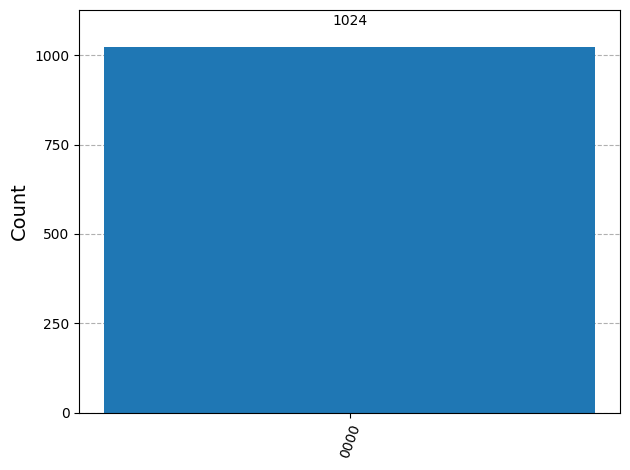


Secret s = 0001
Counts (logical order): {'0001': 1024}
Most frequent: 0001 Match: True


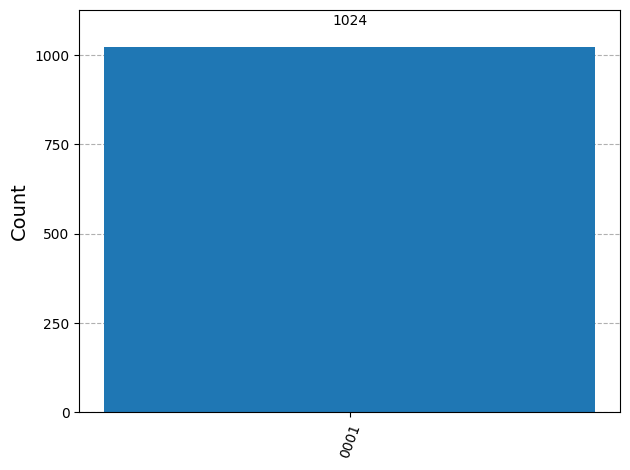


Secret s = 0010
Counts (logical order): {'0010': 1024}
Most frequent: 0010 Match: True


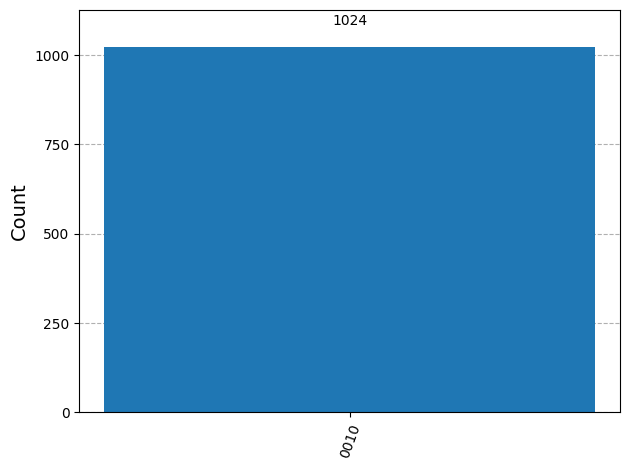


Secret s = 0101
Counts (logical order): {'0101': 1024}
Most frequent: 0101 Match: True


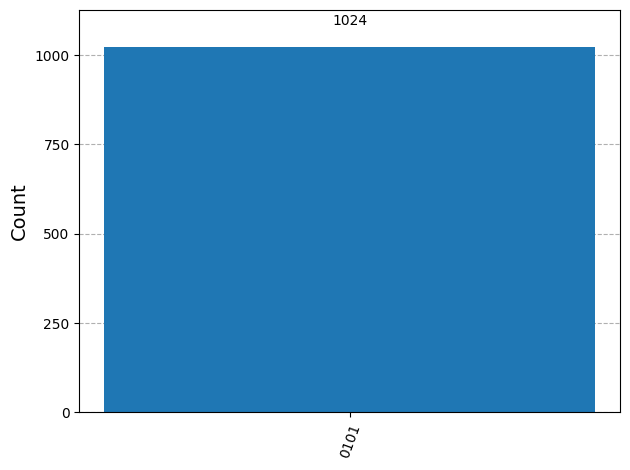


Secret s = 1111
Counts (logical order): {'1111': 1024}
Most frequent: 1111 Match: True


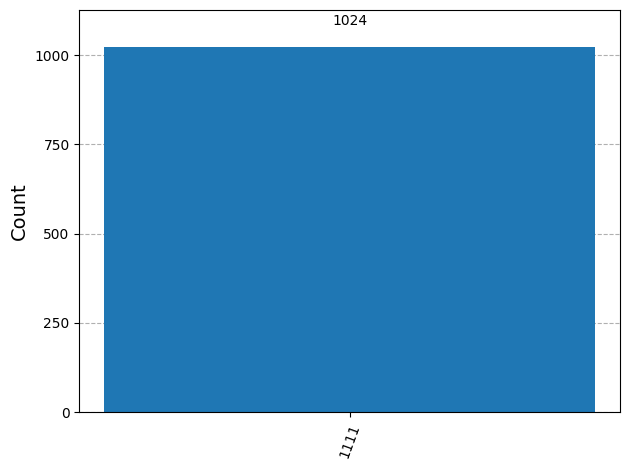


Secret s = 1011
Counts (logical order): {'1011': 1024}
Most frequent: 1011 Match: True


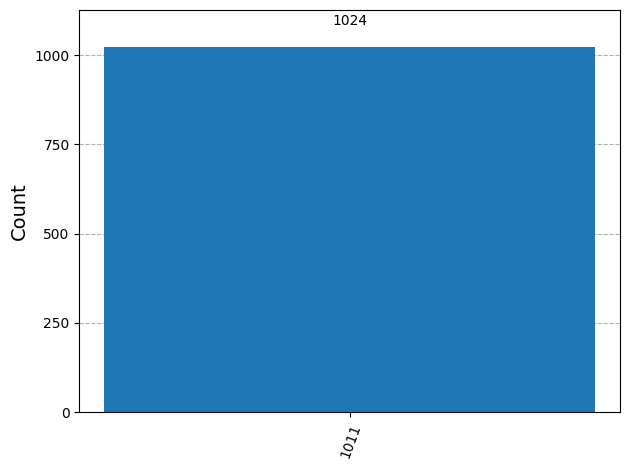

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel, depolarizing_error
def bv_oracle(qc, inputs, ancilla, s, b='0'):
    if b == '1':
        qc.x(ancilla)
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

def bernstein_vazirani_circuit(s, b='0'):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n
    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle(qc, inputs, ancilla, s, b=b)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, creg)
    return qc

def normalize_counts(counts):
    return {k[::-1]: v for k, v in counts.items()}

def run_on_simulator(qc, shots=1024, noise_model=None):
    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    res = job.result()
    counts = res.get_counts()
    return normalize_counts(counts)

def build_simple_noise_model(p1=0.001, p2=0.01):
    nm = NoiseModel()
    e1 = depolarizing_error(p1, 1)
    e2 = depolarizing_error(p2, 2)
    nm.add_all_qubit_quantum_error(e1, ['u1','u2','u3','id','x','h'])
    nm.add_all_qubit_quantum_error(e2, ['cx','cz'])
    return nm

secrets = ['0000', '0001', '0010', '0101', '1111', '1011']
for s in secrets:
    print('\nSecret s =', s)
    qc = bernstein_vazirani_circuit(s)
    counts = run_on_simulator(qc, shots=1024)
    print('Counts (logical order):', counts)
    most = max(counts, key=counts.get)
    print('Most frequent:', most, 'Match:', most==s)
    display(plot_histogram(counts))

# **Task 2 : Modify the oracle to include an additional constant bit b (i.e., implement f(x) = s·x ⊕ b) and show how b affects the ancilla only.**


Testing: s = 1011, b = 0
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║  ║ 
c: 4/═════════════════╩═════════════╩═══════╩══╩═
                      1             0       2  3 
Counts: {'1101': 1024}
Measured (reversed): 1011
Note: b=0 does not affect the measured result for s

Testing: s = 1011, b = 1
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫──────────

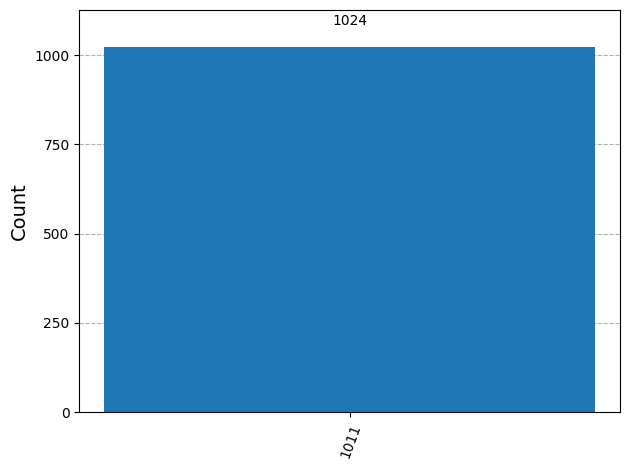

Most frequent: 1011

Using b = 1
Counts (logical order): {'1011': 1024}


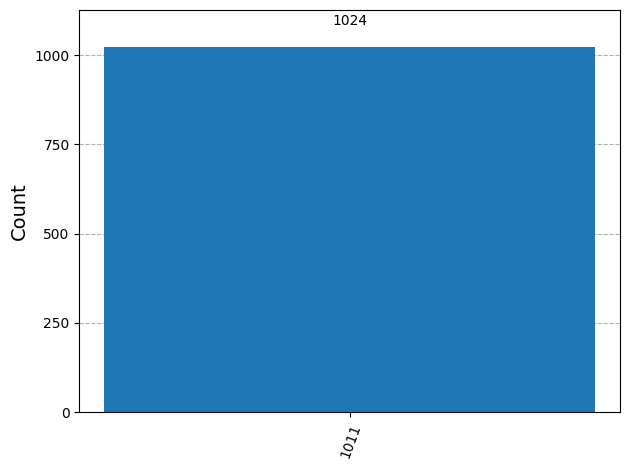

Most frequent: 1011

Explanation: b toggles ancilla; measured input register remains the same.


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def bv_oracle_with_b(qc, inputs, ancilla, s, b):
    """Implements oracle for f(x) = s · x ⊕ b."""
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

    if b == '1':
        qc.x(ancilla)

def bernstein_vazirani_circuit_with_b(s, b):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle_with_b(qc, inputs, ancilla, s, b)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, creg)
    return qc

def run_bv_with_b(qc, shots=1024):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

# Test with b = 0 and b = 1
s = '1011'

for b in ['0', '1']:
    print(f'\nTesting: s = {s}, b = {b}')
    qc = bernstein_vazirani_circuit_with_b(s, b)
    print(qc.draw())

    counts = run_bv_with_b(qc)
    print('Counts:', counts)
    plot_histogram(counts, title=f's={s}, b={b}')
    plt.show()

    most = max(counts, key=counts.get)
    measured_reversed = most[::-1]
    print(f'Measured (reversed): {measured_reversed}')
    print(f'Note: b={b} does not affect the measured result for s')
    s = '1011'
for b in ['0','1']:
    print('\nUsing b =', b)
    qc = bernstein_vazirani_circuit(s, b=b)
    counts = run_on_simulator(qc, shots=1024)
    print('Counts (logical order):', counts)
    display(plot_histogram(counts))
    print('Most frequent:', max(counts, key=counts.get))

print('\nExplanation: b toggles ancilla; measured input register remains the same.')

# **Task 3 : Run on a real IBM backend using qiskit_ibm_runtime and compare results with the simulator (Optional)**

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def bv_oracle(qc, inputs, ancilla, s):
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

def bernstein_vazirani_circuit(s):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle(qc, inputs, ancilla, s)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, creg)
    return qc

def create_noise_model(error_rate):
    noise_model = NoiseModel()
    error_1q = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
    error_2q = depolarizing_error(error_rate * 2, 2)
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    return noise_model

def run_bv_with_noise(qc, noise_model=None, shots=1024):
    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

# Test with different noise levels
s = '1011'
error_rates = [0.0, 0.01, 0.05, 0.1]
shots = 2048

print(f'Secret string s = {s}\n')

for error_rate in error_rates:
    print(f'Error Rate: {error_rate:.2%}')
    qc = bernstein_vazirani_circuit(s)

    noise_model = None if error_rate == 0.0 else create_noise_model(error_rate)
    counts = run_bv_with_noise(qc, noise_model, shots)

    most = max(counts, key=counts.get)
    measured_reversed = most[::-1]
    success_rate = counts[most] / shots * 100

    print(f'Measured: {measured_reversed}, Success Rate: {success_rate:.1f}%')
    print(f'Top results: {dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:3])}')

    plot_histogram(counts, title=f'Error Rate: {error_rate:.2%}')
    plt.show()
    print()

Secret string s = 1011

Error Rate: 0.00%
Measured: 1011, Success Rate: 100.0%
Top results: {'1101': 2048}

Error Rate: 1.00%
Measured: 1011, Success Rate: 92.2%
Top results: {'1101': 1888, '0101': 46, '1001': 38}

Error Rate: 5.00%
Measured: 1011, Success Rate: 68.8%
Top results: {'1101': 1408, '0101': 154, '1001': 127}

Error Rate: 10.00%
Measured: 1011, Success Rate: 45.8%
Top results: {'1101': 939, '0101': 269, '0000': 214}



# **Task 4 : Add noise via qiskit_aer.noise.NoiseModel and analyze robustness**

BERNSTEIN-VAZIRANI ALGORITHM - STEP BY STEP

Secret string: s = 101
Goal: Recover s using only 1 quantum query

STEP 1: Initialize qubits
- Input qubits initialized to |0⟩
- Ancilla qubit initialized to |1⟩
          
q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════
          

STEP 2: Apply Hadamard gates to create superposition
- All qubits now in superposition
- Input qubits: equal superposition of all n-bit strings
- Ancilla: in state |-⟩ = (|0⟩-|1⟩)/√2
     ┌───┐      ░ 
q_0: ┤ H ├──────░─
     ├───┤      ░ 
q_1: ┤ H ├──────░─
     ├───┤      ░ 
q_2: ┤ H ├──────░─
     ├───┤┌───┐ ░ 
q_3: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c: 3/═════════════
                  

STEP 3: Apply oracle
Oracle implements f(x) = s·x where s = 101
- Apply CNOT: q_0 → ancilla (because s[0]=1)
- Apply CNOT: q_2 → ancilla (because s[2]=1)
- Oracle creates phase kickback based on s·x
     ┌───┐      ░            ░ 
q_0: ┤ H ├──────░───■────────░─
     ├───┤     

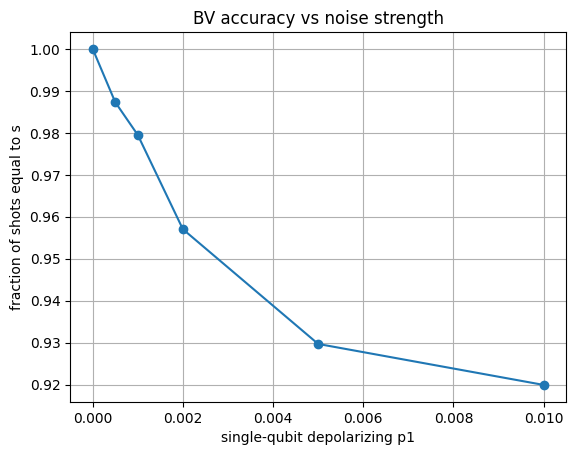

KEY POINTS
1. Classical algorithm needs n queries
2. Quantum algorithm needs only 1 query
3. Uses superposition and interference
4. Result is deterministic (100% success)


In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

print("="*60)
print("BERNSTEIN-VAZIRANI ALGORITHM - STEP BY STEP")
print("="*60)

s = '101'
n = len(s)

print(f"\nSecret string: s = {s}")
print(f"Goal: Recover s using only 1 quantum query\n")

# Step 1: Initialize
print("STEP 1: Initialize qubits")
qreg = QuantumRegister(n + 1, 'q')
creg = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qreg, creg)
qc.x(n)
print("- Input qubits initialized to |0⟩")
print("- Ancilla qubit initialized to |1⟩")
print(qc.draw())

# Step 2: Hadamard gates
print("\nSTEP 2: Apply Hadamard gates to create superposition")
qc.h(qreg)
qc.barrier()
print("- All qubits now in superposition")
print("- Input qubits: equal superposition of all n-bit strings")
print("- Ancilla: in state |-⟩ = (|0⟩-|1⟩)/√2")
print(qc.draw())

# Step 3: Oracle
print("\nSTEP 3: Apply oracle")
print(f"Oracle implements f(x) = s·x where s = {s}")
for i, bit in enumerate(s):
    if bit == '1':
        qc.cx(i, n)
        print(f"- Apply CNOT: q_{i} → ancilla (because s[{i}]=1)")
qc.barrier()
print("- Oracle creates phase kickback based on s·x")
print(qc.draw())

# Step 4: Hadamard again
print("\nSTEP 4: Apply Hadamard to input qubits")
for q in range(n):
    qc.h(q)
print("- Second Hadamard causes interference")
print("- Correct answer (s) amplified, others cancel")
print(qc.draw())

# Step 5: Measure
print("\nSTEP 5: Measure input qubits")
qc.measure(range(n), creg)
print(qc.draw())

# Run circuit
print("\n" + "="*60)
print("EXECUTION")
print("="*60)
sim = AerSimulator()
tqc = transpile(qc, sim)
job = sim.run(tqc, shots=1024)
result = job.result()
counts = result.get_counts()

print(f"Counts: {counts}")
plot_histogram(counts, title=f'Results for s={s}')
plt.show()

most = max(counts, key=counts.get)
measured_reversed = most[::-1]

print(f"\nSecret string s: {s}")
print(f"Measured result:  {measured_reversed}")

if measured_reversed == s:
    print("✅ Successfully recovered secret string in 1 query!")
else:
    print("Note: Check bit ordering")

print("\n" + "="*60)

import numpy as np
def bv_accuracy_under_noise(s='1011', p1_list=None, shots=1024):
    if p1_list is None:
        p1_list = [0.0, 0.0005, 0.001, 0.002, 0.005, 0.01]
    accuracies = []
    for p1 in p1_list:
        p2 = min(0.02, p1*10)
        nm = build_simple_noise_model(p1=p1, p2=p2)
        qc = bernstein_vazirani_circuit(s)
        counts = run_on_simulator(qc, shots=shots, noise_model=nm)
        most = max(counts, key=counts.get)
        acc = 1.0 if most == s else 0.0
        # for a better estimate, compute fraction of shots that equal s
        fraction = counts.get(s, 0) / shots
        accuracies.append((p1, fraction))
        print(f'p1={p1:.6f}  fraction_correct={fraction:.4f}  most={most}')
    # plot
    ps = [x[0] for x in accuracies]
    fr = [x[1] for x in accuracies]
    plt.figure()
    plt.plot(ps, fr, marker='o')
    plt.xlabel('single-qubit depolarizing p1')
    plt.ylabel('fraction of shots equal to s')
    plt.title('BV accuracy vs noise strength')
    plt.grid(True)
    plt.show()

bv_accuracy_under_noise('1011', shots=1024)
print("KEY POINTS")
print("="*60)
print("1. Classical algorithm needs n queries")
print("2. Quantum algorithm needs only 1 query")
print("3. Uses superposition and interference")
print("4. Result is deterministic (100% success)")

# **Task 5 : Create a notebook that explains each step with visualizations and markdown**

### 🧠 Bernstein–Vazirani Algorithm Overview

- *Goal:* Find a hidden bit string s using a single query to the oracle.
- *Oracle Function:*  
  \( f(x) = s \cdot x \oplus b \)
  where  
  - s · x is the bitwise dot product mod 2  
  - b is an optional constant bit.

*Steps:*
1. Initialize n input qubits and one ancilla.
2. Apply X to the ancilla → creates |1⟩.
3. Apply Hadamard (H) to all qubits.
4. Call the oracle.
5. Apply Hadamard to inputs again.
6. Measure the input qubits — result reveals s.

🧩 If b=1, only the *ancilla’s phase* changes, not the measured bitstring.
